In [14]:
# imports and config constants (refactored to per-agent modules)
import os, json, pathlib
from datetime import datetime
from typing import Dict, List
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import importlib
from IPython.display import Image

# Load .env 
from dotenv import load_dotenv
load_dotenv()

# Add project root to Python path
project_root = Path.cwd().parent 
sys.path.insert(0, str(project_root))

# Display model environment variables used by agents
print({k: os.getenv(k) for k in [
    "MODEL_NAME",
    "TEACHER_MODEL",
    "GRADING_MODEL",
    "COORDINATOR_MODEL",
    "STUDENT_MODEL",
    "CRITIQUE_EVAL_MODEL",
]})

{'MODEL_NAME': 'gpt-4o-mini', 'TEACHER_MODEL': 'gpt-4o-mini', 'GRADING_MODEL': 'gpt-4o-mini', 'COORDINATOR_MODEL': 'gpt-4o-mini', 'STUDENT_MODEL': 'gpt-4o-mini', 'CRITIQUE_EVAL_MODEL': 'gpt-4o-mini'}


In [15]:
from src.graphs.adaptive_refinement_graph import create_adaptive_refinement_graph, create_initial_state as adaptive_state
from src.graphs.baseline_graph import create_baseline_graph, create_initial_state as baseline_state
from src.utils.gpqa_sampler import create_gpqa_quiz

THRESHOLD = 0.7
MAX_ITERS = 3
BASE_OUT = pathlib.Path("results")
BASE_OUT.mkdir(parents=True, exist_ok=True)

In [16]:
# Run baseline
baseline_graph = create_baseline_graph()

# Run adaptive
adaptive_graph = create_adaptive_refinement_graph()

In [17]:
# optional: initialize TruLens OpenAI provider to compute simple relevance
try:
    from trulens.providers.openai import OpenAI as TruOpenAI
    tru_provider = TruOpenAI(model_engine="gpt-4o-mini")
except Exception as e:
    tru_provider = None
    print("TruLens provider init failed:", e)

In [18]:
# TruLens LangGraph recorder (logs interactions)
try:
    from trulens.core.database.connector.default import DefaultDBConnector
    from trulens.core.session import TruSession
    from trulens.apps.langgraph import TruGraph

    connector = DefaultDBConnector(database_url="sqlite:///edu_refine.sqlite")
    tru_session = TruSession(connector=connector)
    
    # Separate recorders for each graph
    baseline_recorder = TruGraph(
        baseline_graph, 
        app_name="Baseline Agent", 
        app_version="v1"
    )
    adaptive_recorder = TruGraph(
        adaptive_graph, 
        app_name="Adaptive Refinement Agent", 
        app_version="v1"
    )
    
except Exception as e:
    baseline_recorder = None
    adaptive_recorder = None
    print("TruGraph init failed:", e)

Singleton instance TruSession already exists for name = None.


🦑 Initialized with db url sqlite:///edu_refine.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `TruSession` to prevent this.
instrumenting <class 'langgraph.graph.state.StateGraph'> for base <class 'langgraph.graph.state.StateGraph'>
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.graph.state.CompiledStateGraph'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.pregel.main.Pregel'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
instrumenting <class 'langgraph.graph.state.StateGraph'> for base <class 'langgraph.graph.state.StateGraph'>
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.graph.state.CompiledStateGraph'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream

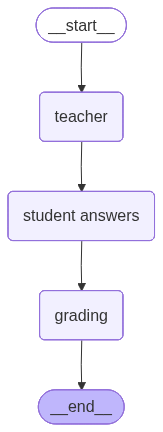

In [6]:
display(Image(baseline_graph.get_graph().draw_mermaid_png()))

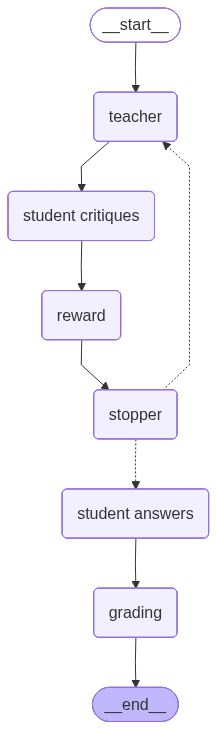

In [7]:
display(Image(adaptive_graph.get_graph().draw_mermaid_png()))

In [8]:
quiz, indices = create_gpqa_quiz(num_questions=5)

Loading GPQA cache from: C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics_train.json
Loaded 187 Physics questions from gpqa_main


In [23]:
# Run baseline with recording
if 'baseline_recorder' in globals() and baseline_recorder is not None:
    with baseline_recorder as recording:
        baseline_results = baseline_graph.invoke(baseline_state(quiz[3]),
                                                config={"recursion_limit": 30})

In [20]:
# Run adaptive with recording  
if 'adaptive_recorder' in globals() and adaptive_recorder is not None:
    with adaptive_recorder as recording:
        adaptive_results = adaptive_graph.invoke(adaptive_state(quiz[3], max_iters = 3),
                                                config={"recursion_limit": 30})

In [24]:
baseline_results['quiz_results']

{'total_questions': 1,
 'correct_counts': {'advanced': 0,
  'struggling': 0,
  'skeptical_misconception': 0,
  'practical': 0,
  'theoretical': 0},
 'scores_by_persona': {'advanced': 0.09999999999999998,
  'struggling': 0.10999999999999999,
  'skeptical_misconception': 0.10999999999999999,
  'practical': 0.10999999999999999,
  'theoretical': 0.10999999999999999},
 'justification_scores_by_persona': {'advanced': 0.5,
  'struggling': 0.55,
  'skeptical_misconception': 0.55,
  'practical': 0.55,
  'theoretical': 0.55},
 'overall_score': 0.10799999999999998}

In [21]:
adaptive_results['quiz_results']

{'total_questions': 1,
 'correct_counts': {'advanced': 0,
  'struggling': 0,
  'skeptical_misconception': 0,
  'practical': 0,
  'theoretical': 0},
 'scores_by_persona': {'advanced': 0.10999999999999999,
  'struggling': 0.06999999999999998,
  'skeptical_misconception': 0.07999999999999999,
  'practical': 0.10999999999999999,
  'theoretical': 0.06999999999999998},
 'justification_scores_by_persona': {'advanced': 0.55,
  'struggling': 0.35,
  'skeptical_misconception': 0.4,
  'practical': 0.55,
  'theoretical': 0.35},
 'overall_score': 0.088}

In [25]:
baseline_results['explanation']

'To understand this problem, we need to explore the concepts of quantum superposition, spin operators, and expectation values. A spin-half particle, like an electron, can exist in a superposition of spin states, represented here as a linear combination of spin-up \\(|\\uparrow\\rangle\\) and spin-down \\(|\\downarrow\\rangle\\) states. The operators \\(\\sigma_z\\) and \\(\\sigma_x\\) are Pauli matrices, which are used to describe spin measurements along the z-axis and x-axis, respectively. The Pauli matrices are defined as \\(\\sigma_z = \\begin{pmatrix} 1 & 0 \\\\ 0 & -1 \\end{pmatrix}\\) and \\(\\sigma_x = \\begin{pmatrix} 0 & 1 \\\\ 1 & 0 \\end{pmatrix}\\). The expectation value of an operator \\(A\\) for a state \\(|\\psi\\rangle\\) is given by \\(\\langle \\psi | A | \\psi \\rangle\\). For the given superposition state, calculate the expectation value of each component separately: \\(10\\sigma_z\\) and \\(5\\sigma_x\\). Use the linearity of expectation values to combine these res

In [29]:
adaptive_results['history'][0]['explanation']

'In quantum mechanics, the expectation value of an operator gives the average outcome of a measurement over many trials. For a spin-half particle in a superposition state, the expectation value of an operator is calculated using the formula ⟨ψ|A|ψ⟩, where |ψ⟩ is the state vector and A is the operator. Here, the state |ψ⟩ = 0.5|↑⟩ + √3/2|↓⟩ is a superposition of the spin-up |↑⟩ and spin-down |↓⟩ states. The operator in question is 10σ_z + 5σ_x, where σ_z and σ_x are the Pauli matrices. The Pauli matrix σ_z has eigenvalues +1 and -1 for |↑⟩ and |↓⟩, respectively, while σ_x has matrix elements that mix these states. To find the expectation value, compute the matrix elements of the operator in the given state. For example, σ_z contributes terms based on the probabilities of being in |↑⟩ or |↓⟩, while σ_x involves off-diagonal terms. The expectation value is a weighted sum of these contributions, reflecting the average measurement outcome for the operator in this quantum state.'

In [26]:
adaptive_results['explanation']

"In quantum mechanics, a spin-half particle in a superposition state like 0.5|↑⟩ + √3/2|↓⟩ is simultaneously in both spin-up and spin-down states with certain probabilities. The coefficients 0.5 and √3/2 represent the probability amplitudes, and their squares give the probabilities of measuring the particle in each state. The expectation value of an operator, such as 10σ_z + 5σ_x, is the average outcome of many measurements on identically prepared systems. To find this, calculate the state after applying the operator: A|ψ⟩. For σ_z, it acts on |↑⟩ and |↓⟩ as +1 and -1, respectively. For σ_x, it swaps |↑⟩ and |↓⟩. The dot product ⟨ψ|A|ψ⟩ gives the expectation value, combining probabilities and operator effects. Here, ⟨ψ| is the conjugate transpose of |ψ⟩. The expectation value is a weighted sum of the operator's eigenvalues, reflecting the probabilities of each state. This process reveals the average measurement outcome of the operator in the given quantum state."

In [30]:
adaptive_results['gpqa_question']

{'id': 'rec0wZvZgiz320KRs',
 'question': 'A spin-half particle is in a linear superposition 0.5|\\uparrow\\rangle+sqrt(3)/2|\\downarrow\\rangle of its spin-up and spin-down states. If |\\uparrow\\rangle and |\\downarrow\\rangle are the eigenstates of \\sigma{z} , then what is the expectation value up to one decimal place, of the operator 10\\sigma{z}+5\\sigma_{x} ? Here, symbols have their usual meanings',
 'options': ['A) 0.85', 'B) -0.7', 'C) -1.4', 'D) 1.65'],
 'correct': 'B',
 'explanation': '|psi> = 0.5 |up=0> + sqrt(3)/2|down=1> \nIf the operator can be written as A,\nthen the expectation value is,\n = -0.7'}

In [6]:
initial_state = {
    "gpqa_question": quiz[0],
    "threshold": THRESHOLD,
    "max_iters": MAX_ITERS,
    "history": []
}

if 'tru_recorder' in globals() and tru_recorder is not None:
    with tru_recorder as recording:
        state = adaptive_graph.invoke(initial_state, config={"recursion_limit": 30})
else:
    state = adaptive_graph.invoke(initial_state, config={"recursion_limit": 30})

results = {
    "dataset": "GPQA",
    "subset": subset,
    "domain": domain,
    "gpqa_index": idx,
    "record_id": record_id,
    "question": state.get("question", QUESTION),
    "topics": state.get("topics", []),
    "iterations": state.get("iteration", 0),
    "final_scores": state.get("reward_scores", {}),
    "final_explanation": state.get("explanation", ""),
    "history": state.get("history", []),
    "quiz": state.get("quiz", GPQA_QUIZ),
    "quiz_answers": state.get("quiz_answers", {}),
    "quiz_justifications": state.get("quiz_justifications", {}),
    "quiz_results": state.get("quiz_results", {}),
}

print("Dataset:", results["dataset"], results["subset"], results["domain"]) 
print("Record ID:", results["record_id"]) 
print("Question:", results["question"]) 
print("Topics:", ", ".join(results["topics"]))
print("Iterations:", results["iterations"]) 
print("Final scores:", results["final_scores"]) 
print("\nFinal explanation (truncated to 800 chars):\n")
print(results["final_explanation"][:800])

# Print quiz and persona answers with justifications
quiz = results.get("quiz", [])
answers = results.get("quiz_answers", {})
justifs = results.get("quiz_justifications", {})
if quiz:
    q0 = quiz[0]
    print("\nQuiz (GPQA single question):")
    print(f"- ID: {q0.get('id','')}")
    print(f"  Stem: {q0.get('stem','').strip()}")
    for opt in q0.get("options", []):
        print(f"  {opt}")
    print(f"  Correct: {q0.get('correct','?')}")

    if answers:
        print("\nStudent answers and justifications:")
        for p in sorted(answers.keys()):
            a_map = answers.get(p, {})
            j_map = justifs.get(p, {})
            letter = a_map.get(str(q0.get('id')), '?')
            jtxt = j_map.get(str(q0.get('id')), '')
            print(f"- {p}: {letter}")
            if jtxt:
                print(f"  Justification: {jtxt}")

quiz_results = results.get("quiz_results", {})
if quiz_results:
    total = quiz_results.get("total_questions", 0)
    overall = quiz_results.get("overall_score", 0.0)
    scores_by_persona = quiz_results.get("scores_by_persona", {})
    correct_counts = quiz_results.get("correct_counts", {})
    just_scores = quiz_results.get("justification_scores_by_persona", {})
    print("\nQuiz Results:")
    print(f"- Total questions: {total}")
    print(f"- Overall score: {overall*100:.1f}%")
    print("- Scores by persona:")
    for p in sorted(scores_by_persona.keys()):
        sc = scores_by_persona[p]
        cc = correct_counts.get(p, 0)
        js = just_scores.get(p, 0.0)
        print(f"  {p}: {sc*100:.1f}% (correct {cc}/{total}, justification {js*100:.1f}%)")

# Persist results to results/ with timestamped filename
_ts = datetime.now().strftime("%Y%m%d_%H%M%S")

def _slugify(s: str, limit: int = 40) -> str:
    s = (s or "").strip()
    slug = "".join(ch if ch.isalnum() else "_" for ch in s)
    return slug[:limit] if limit > 0 else slug

_id_part = str(record_id) if record_id is not None else _slugify(results["question"]) or "run"
outfile = BASE_OUT / f"run_{_ts}_{_id_part}.json"
record = {
    "timestamp": _ts,
    "dataset": results["dataset"],
    "subset": results["subset"],
    "domain": results["domain"],
    "gpqa_index": idx,
    "record_id": record_id,
    "question": results["question"],
    "final_explanation": results["final_explanation"],
    "topics": results["topics"],
    "iterations": results["iterations"],
    "final_scores": results["final_scores"],
    "quiz": results.get("quiz", []),
    "quiz_answers": results.get("quiz_answers", {}),
    "quiz_justifications": results.get("quiz_justifications", {}),
    "quiz_results": results.get("quiz_results", {}),
}
outfile.write_text(json.dumps(record, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"\nSaved results to: {outfile}")

C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics.json
Loading GPQA cache from: C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics.json
Loaded 187 Physics questions from gpqa_main
Dataset: GPQA gpqa_main Physics
Record ID: recvlnu8BuLmXZhSX
Question: The state of a system at time t is given by the column matrix having elements (-1, 2, 1). An observable of the system is represented by the matrix operator P having elements in the first row as (0, 1/ \sqrt{2}, 0),  in the second row as (1/ \sqrt{2}, 0, 1/ \sqrt{2}) and in the third row as (0, 1/ \sqrt{2}, 0). Calculate the probability that the measurement of the observable will yield 0 at time t.
Topics: Understanding state vectors and column matrices, Introduction to observable operators in quantum mechanics, Matrix multiplication and its relevance in quantum measurements, Calculating probabilities from measurement operators, Eigenvalues and eigenvectors of observable matri

In [13]:
# launch TruLens dashboard to view agent interactions
from trulens.dashboard import run_dashboard
run_dashboard()  # prints a local URL (e.g., http://localhost:8501); open it in your browser

Starting dashboard ...


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at http://localhost:60857 .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>